# History Matching L96
Author: Redouane Lguensat

Date: 26/07/2021

In [6]:
from L96 import * #https://github.com/raspstephan/Lorenz-Online
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
np.random.seed(42)

X_init = 10 * np.ones(36)
X_init[18] = 10 + 0.01

l96_two = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [8]:
l96_two.iterate(10)

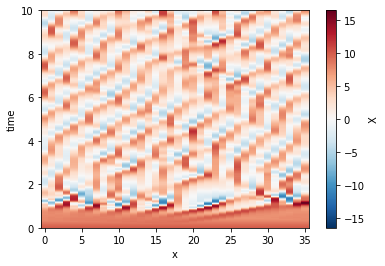

In [9]:
l96_two.history.X.plot()

#### take the last state as an init for a new simulation
since now we are sure that it starts from the attractor

In [10]:
Newinit = l96_two.history.X[-1,:].values
Newinit

array([ 2.60122824, -0.59213617, -1.17373327,  1.84938332,  8.68045117,
        3.46059218,  0.25781228,  1.2653452 ,  1.08225301,  0.8753893 ,
        8.97733208,  6.18802886,  1.94032476,  1.88401847,  4.37917481,
       -1.81942909, 10.94394167,  3.59440247, -1.43808455, -0.99906739,
       -0.49279472,  2.07853127, -0.63479542, 10.33846187,  5.62458241,
        1.20973551,  1.19944234, -3.27853949, -2.96779466,  4.56265636,
        7.60216092,  2.54621466,  0.40105946, -4.41037045,  1.36549073,
        7.4825951 ])

In [11]:
np.random.seed(42)

l96_two_truth = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=Newinit, integration_type='coupled') 

In [12]:
l96_two_truth.iterate(100)

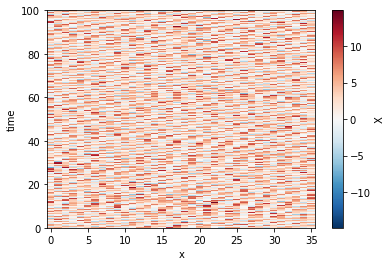

In [13]:
l96_two_truth.history.X.plot()

This is our ground truth

In [14]:
#sns.set_context("talk")
#fig = l96_two_truth.history.X[:5000,0].plot(label=r'$X_1$')
#l96_two_truth.history.Y_sum[:5000,0].plot(label=r'$\sum_{j=1}^{J=10} Y_{j,1}$', color='magenta')
#plt.legend(prop={'size': 12})
#fig[0].get_figure().gca().set_ylabel("Amplitude")
#fig[0].get_figure().gca().set_xlabel("Time")
#fig[0].get_figure().gca().set_title("")

# Metrics

We will use the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
X \\
\bar{Y} \\
X^{2} \\
X \bar{Y}\\
\bar{Y}^{2}
\end{array}\right)
$$

# History Matching

We want to find the parameters (h, F, c, b)

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} - \underbrace{\frac{h c}{b} \Sigma_j Y_{j,k}}_{\text {Coupling}}$

$ \frac{d Y_{j, k}}{d t}=\underbrace{-b c Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{- c Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h c}{b} X_{k}}_{\text {Coupling }}$

# Wave1

calculate metrics for the true trajectory

In [15]:
TrueTraj = l96_two_truth.mean_stats(ax=0)[list(range(0,36))+list(range(36*2,36*4)),]

Define metric 

In [16]:
def metric(params, Ysumdata):
    l96param = OMIP(Ysumdata=Ysumdata,
                    K=36,
                    save_dt=0.001,
                    X_init = Newinit,#l96param_spinup.history.X[-1,:].values,
                    G=params[0],
                    F=params[1]) 
    l96param.iterate(100)
    return l96param.mean_stats(ax=0)[list(range(0,36))+list(range(36*2,36*4)),]

Sanity check with the true params

In [19]:
sancheck = metric(np.array([1.,10.]), l96_two_truth.history.Y_sum) 

In [118]:
#l96_two_truth.history.Y_sum-10*l96_two_truth.history.Y_mean

In [119]:
#sancheck.history.X.plot()
#plt.figure()
#l96_two_truth.history.X.plot()
#plt.figure()
#(sancheck.history.X-l96_two_truth.history.X).plot()

In [20]:
np.mean((TrueTraj - sancheck)**2) ### 0 with uncoupled

4.0457915394171

In [64]:
np.mean((TrueTraj - sancheck)**2) ### h=1/8

2.5010506201235096

In [120]:
np.mean((TrueTraj - sancheck)**2) ### h=1/16

2.5212140361395488

# Running the 20 simulations in parallel

In [21]:
inputs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_inputs_newPCA_PhysPrior_OMIP_wave1.csv").values

In [22]:
inputs

array([[13.36501412, 15.63072615],
       [ 5.28012463,  5.41877162],
       [ 9.59971585, 11.87926595],
       [15.81856961,  8.10798707],
       [19.09783228, 10.9802787 ],
       [14.96368953,  2.26496663],
       [ 6.16873644,  0.08427752],
       [ 3.08608341, 16.38590718],
       [ 4.8612107 ,  6.12489583],
       [ 8.5247906 ,  7.58155422],
       [11.65681088, 17.24014961],
       [17.22951937, 12.72188789],
       [ 0.72122603, 14.14592869],
       [12.49075039,  9.15283877],
       [10.96525559,  1.25922267],
       [ 7.90694248, 13.77788626],
       [16.55125053,  4.4264663 ],
       [ 1.0755991 , 19.06004834],
       [ 2.02270001,  3.11483254],
       [18.51323953, 18.4827569 ]])

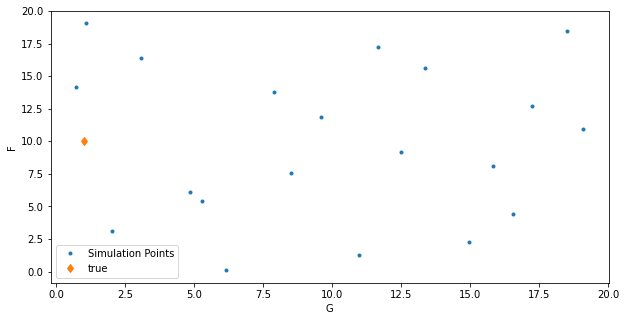

In [23]:
plt.figure(figsize=(10,5))
plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("G")
plt.ylabel("F")
plt.legend()

In [24]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_cores

80

In [25]:
import joblib
joblib.__version__

'1.0.0'

In [26]:
%%time

results = Parallel(n_jobs=40)(delayed(metric)(i,l96_two_truth.history.Y_sum) for i in inputs)

targets = np.array(results)

CPU times: user 15.2 s, sys: 3.31 s, total: 18.6 s
Wall time: 1min 38s


In [27]:
inputs = inputs[np.all(np.isfinite(targets), axis=1)]
targets = targets[np.all(np.isfinite(targets), axis=1)]

In [28]:
targets.shape, inputs.shape

((20, 108), (20, 2))

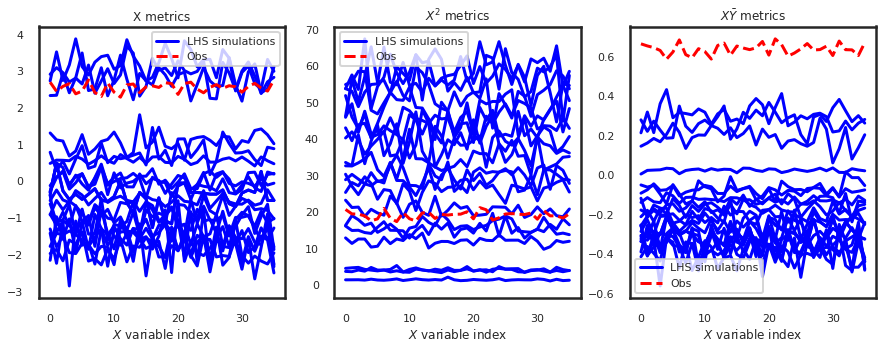

In [41]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 3})

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
for i in range(20):
    plt.plot(targets[i,:36], 'b')
plt.plot(targets[i,:36], 'b', label='LHS simulations') 
plt.plot(TrueTraj[:36], 'r--', label='Obs') 
plt.title('X metrics')
plt.xlabel(r'$X$ variable index')
plt.legend()

plt.subplot(1,3,2)
for i in range(20):
    plt.plot(targets[i,36:36*2], 'b')
plt.plot(targets[i,:36:36*2], 'b', label='LHS simulations') 
plt.plot(TrueTraj[36:36*2], 'r--', label='Obs')  
plt.title(r'$X^2$ metrics')
plt.xlabel(r'$X$ variable index')
plt.legend()

plt.subplot(1,3,3)
for i in range(20):
    plt.plot(targets[i,36*2:36*3], 'b')
plt.plot(targets[i,36*2:36*3], 'b', label='LHS simulations') 
plt.plot(TrueTraj[36*2:36*3], 'r--', label='Obs') 
plt.title(r'$X\bar{Y}$ metrics')
plt.xlabel(r'$X$ variable index')
plt.legend()

Text(0.5, 1.0, '$X\\bar{Y}$ metrics')

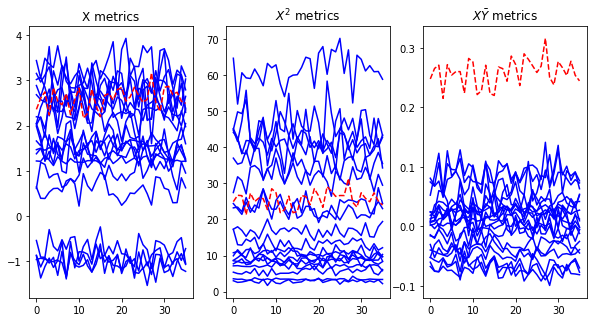

In [73]:
###h=1/8

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
for i in range(20):
    plt.plot(targets[i,:36], 'b')
plt.plot(TrueTraj[:36], 'r--')  
plt.title('X metrics')

plt.subplot(1,3,2)
for i in range(20):
    plt.plot(targets[i,36:36*2], 'b')
plt.plot(TrueTraj[36:36*2], 'r--')  
plt.title(r'$X^2$ metrics')

plt.subplot(1,3,3)
for i in range(20):
    plt.plot(targets[i,36*2:36*3], 'b')
plt.plot(TrueTraj[36*2:36*3], 'r--') 
plt.title(r'$X\bar{Y}$ metrics')

Text(0.5, 1.0, '$X\\bar{Y}$ metrics')

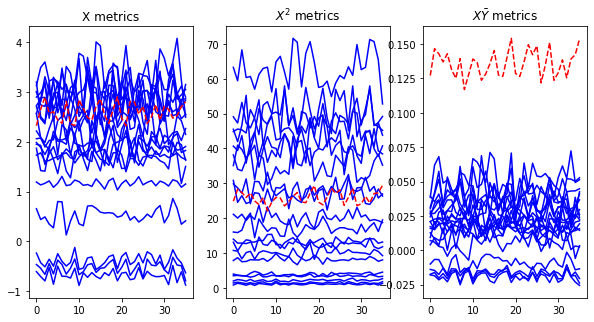

In [129]:
###h=1/16

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
for i in range(20):
    plt.plot(targets[i,:36], 'b')
plt.plot(TrueTraj[:36], 'r--')  
plt.title('X metrics')

plt.subplot(1,3,2)
for i in range(20):
    plt.plot(targets[i,36:36*2], 'b')
plt.plot(TrueTraj[36:36*2], 'r--')  
plt.title(r'$X^2$ metrics')

plt.subplot(1,3,3)
for i in range(20):
    plt.plot(targets[i,36*2:36*3], 'b')
plt.plot(TrueTraj[36*2:36*3], 'r--') 
plt.title(r'$X\bar{Y}$ metrics')

# pca

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduceL96pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    TrueTrajscaled = scaler.transform(TrueTraj[None,:2*36])#2*36
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full')
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    reducedTrueTraj = pca.transform(TrueTrajscaled)
    return reduceddata, reducedTrueTraj, scaler, pca

In [35]:
targetsreduced, Obsreduced, sc, pc = reduceL96pca(targets[:,:2*36])#[:,:2*36]
targetsreduced.shape, Obsreduced.shape

((20, 7), (1, 7))

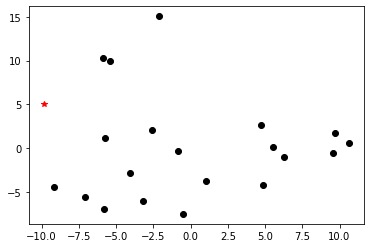

In [36]:
plt.scatter(targetsreduced[:,0],targetsreduced[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

### save dataframes

In [37]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave1.csv', index=False)

In [38]:
df_metrics

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
0,-0.846227,-0.337373,-0.105241,-0.259808,0.128141,0.277628,0.049576
1,-5.794497,-7.028403,0.070765,-0.052794,-0.034345,0.045678,0.097451
2,-4.075691,-2.900924,0.144448,-0.007405,0.025241,0.059498,0.143566
3,6.304016,-1.026535,-0.201743,0.749459,0.447533,-0.086474,0.987316
4,9.719522,1.745087,-1.272319,-1.266780,0.132427,-0.448558,0.178103
5,9.594687,-0.609706,0.056976,1.321176,0.151010,-0.687421,-0.715496
6,-0.508630,-7.541593,-0.157502,-0.103339,-0.321612,-0.314417,0.249071
7,-5.435058,9.922006,0.387838,-0.035678,1.211417,-0.718976,0.088638
8,-7.103026,-5.578422,0.130267,-0.070844,0.150479,0.007268,0.022293
9,-3.213330,-6.054827,-0.170498,0.198092,-0.198488,0.138968,0.034270


In [39]:
df_obs_nonoise = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_obs_nonoise['pca_'+str(i)] = Obsreduced[:,i]
df_obs_nonoise.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_OMIP_wave1.csv', index=False)

## 2) wave 2

In [40]:
inputs2 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_OMIP_wave2.csv").values

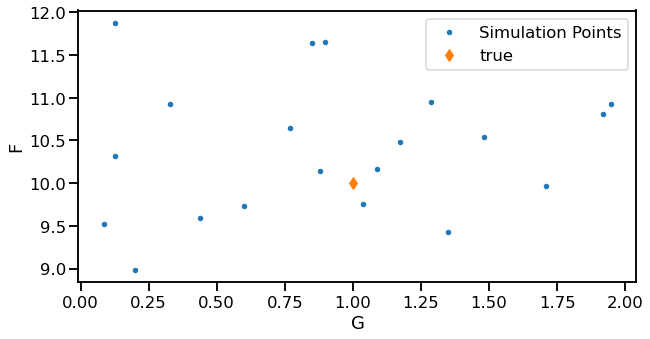

In [41]:
sns.set_context("talk")

plt.figure(figsize=(10,5))
plt.plot(inputs2[:,0], inputs2[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("G")
plt.ylabel("F")
plt.legend()

In [42]:
inputs2.shape

(20, 2)

In [43]:
%%time

results2 = Parallel(n_jobs=40)(delayed(metric)(i, l96_two_truth.history.Y_sum) for i in inputs2)

targets2 = np.array(results2)

CPU times: user 15 s, sys: 3.52 s, total: 18.5 s
Wall time: 1min 39s


In [44]:
inputs2 = inputs2[np.all(np.isfinite(targets2), axis=1)]
targets2 = targets2[np.all(np.isfinite(targets2), axis=1)]

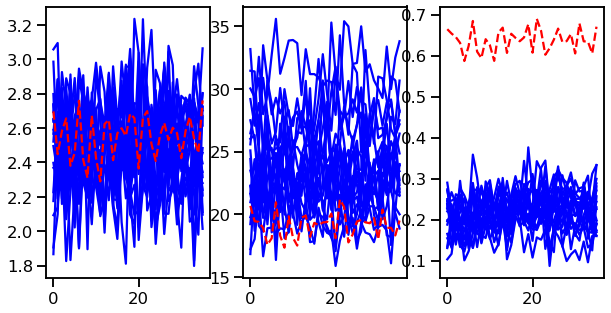

In [45]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
for i in range(20):
    plt.plot(targets2[i,:36], 'b')
plt.plot(TrueTraj[:36], 'r--')  

plt.subplot(1,3,2)
for i in range(20):
    plt.plot(targets2[i,36:36*2], 'b')
plt.plot(TrueTraj[36:36*2], 'r--')  

plt.subplot(1,3,3)
for i in range(20):
    plt.plot(targets2[i,36*2:36*3], 'b')
plt.plot(TrueTraj[36*2:36*3], 'r--') 

In [46]:
def reduceL96pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [47]:
targetsreduced2 = reduceL96pca_usingwave1(targets2[:,:2*36], sc, pc)
targetsreduced2.shape

(20, 7)

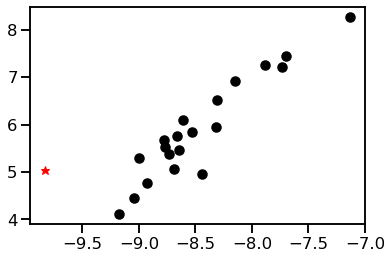

In [48]:
plt.scatter(targetsreduced2[:,0],targetsreduced2[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

In [49]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced2.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced2[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave2.csv', index=False)

In [50]:
df_metrics

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
0,-8.929592,4.772422,0.157045,0.030199,0.308121,-0.155251,-0.003803
1,-8.147921,6.924481,0.005986,0.005626,0.272509,-0.090650,-0.318232
2,-8.613009,6.094114,-0.398820,-0.074399,-0.317297,0.038475,-0.276645
3,-7.729720,7.214751,-0.128364,-0.071851,0.039158,-0.098720,-0.410881
4,-7.133500,8.272090,-0.040538,-0.150893,0.131024,0.060802,-0.467263
5,-8.527989,5.842331,-0.222910,-0.141703,-0.145743,0.034980,-0.396721
6,-7.888079,7.252535,-0.301117,0.007616,0.139603,-0.023136,-0.388541
7,-8.313164,5.956473,-0.043924,-0.183450,0.189895,-0.104819,-0.513527
8,-8.768431,5.524115,0.001576,0.114791,0.072068,-0.235583,-0.230747
9,-9.171767,4.104890,0.074411,0.030170,-0.011032,-0.091914,-0.204680


# wave3

In [62]:
inputs3 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_OMIP_wave3.csv").values

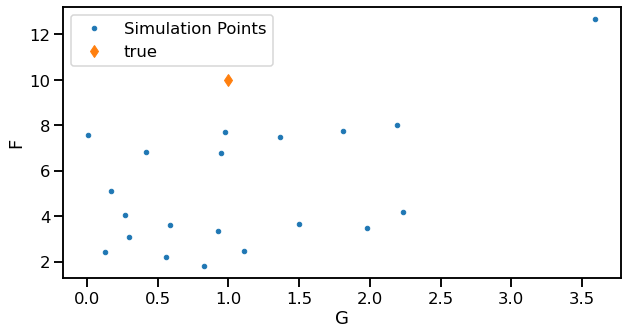

In [63]:
sns.set_context("talk")

plt.figure(figsize=(10,5))
plt.plot(inputs3[:,0], inputs3[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("G")
plt.ylabel("F")
plt.legend()

In [64]:
inputs3.shape

(20, 2)

In [65]:
%%time

results3 = Parallel(n_jobs=20)(delayed(metric)(i, l96_two_truth.history.Y_mean) for i in inputs3)

targets3 = np.array(results3)

CPU times: user 13.2 s, sys: 2.89 s, total: 16.1 s
Wall time: 1min 42s


In [66]:
inputs3.shape, targets3.shape

((20, 2), (20, 72))

In [67]:
inputs3 = inputs3[np.all(np.isfinite(targets3), axis=1)]
targets3 = targets3[np.all(np.isfinite(targets3), axis=1)]

In [68]:
inputs3.shape, targets3.shape

((20, 2), (20, 72))

In [69]:
targetsreduced3 = reduceL96pca_usingwave1(targets3, sc, pc)
targetsreduced3.shape

(20, 5)

In [70]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced3.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced3[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave3.csv', index=False)

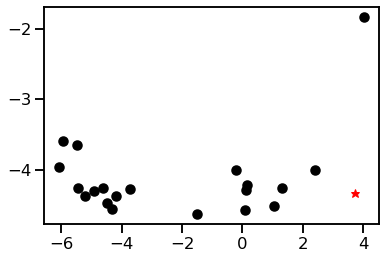

In [71]:
plt.scatter(targetsreduced3[:,0],targetsreduced3[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave4

In [72]:
inputs4 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_OMIP_wave4.csv").values

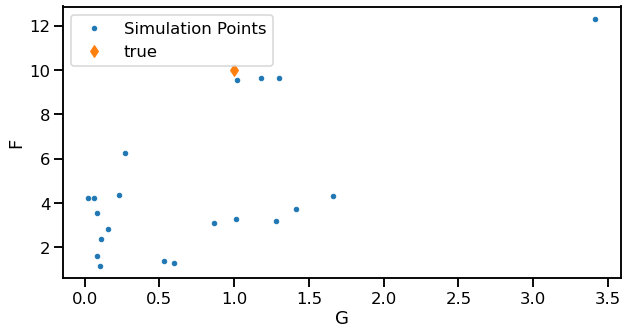

In [73]:
sns.set_context("talk")

plt.figure(figsize=(10,5))
plt.plot(inputs4[:,0], inputs4[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("G")
plt.ylabel("F")
plt.legend()

In [74]:
inputs4.shape

(20, 2)

In [75]:
%%time

results4 = Parallel(n_jobs=20)(delayed(metric)(i, l96_two_truth.history.Y_mean) for i in inputs4)

targets4 = np.array(results4)

CPU times: user 13.3 s, sys: 2.84 s, total: 16.1 s
Wall time: 1min 45s


In [76]:
inputs4.shape, targets4.shape

((20, 2), (20, 72))

In [77]:
inputs4 = inputs4[np.all(np.isfinite(targets4), axis=1)]
targets4 = targets4[np.all(np.isfinite(targets4), axis=1)]

In [78]:
inputs4.shape, targets4.shape

((20, 2), (20, 72))

In [79]:
targetsreduced4 = reduceL96pca_usingwave1(targets4, sc, pc)
targetsreduced4.shape

(20, 5)

In [80]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced4.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced4[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave4.csv', index=False)

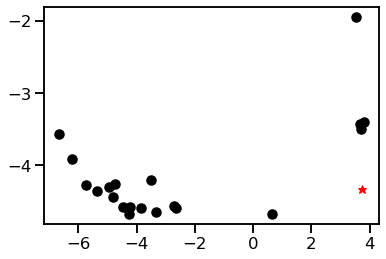

In [81]:
plt.scatter(targetsreduced4[:,0],targetsreduced4[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave5

In [82]:
inputs5 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_OMIP_wave5.csv").values

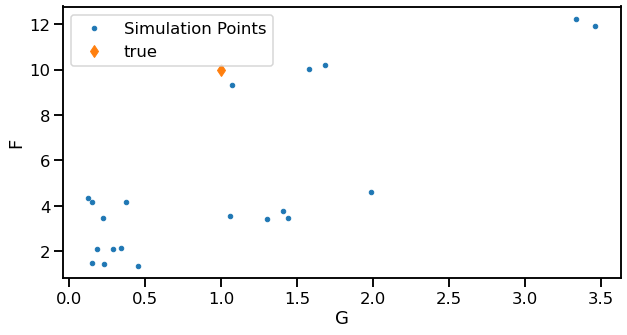

In [83]:
sns.set_context("talk")

plt.figure(figsize=(10,5))
plt.plot(inputs5[:,0], inputs5[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("G")
plt.ylabel("F")
plt.legend()

In [84]:
inputs5.shape

(20, 2)

In [85]:
%%time

results5 = Parallel(n_jobs=20)(delayed(metric)(i, l96_two_truth.history.Y_mean) for i in inputs5)

targets5 = np.array(results5)

CPU times: user 13.4 s, sys: 2.85 s, total: 16.2 s
Wall time: 1min 42s


In [86]:
inputs5.shape, targets5.shape

((20, 2), (20, 72))

In [87]:
inputs5 = inputs5[np.all(np.isfinite(targets5), axis=1)]
targets5 = targets5[np.all(np.isfinite(targets5), axis=1)]

In [88]:
inputs5.shape, targets5.shape

((20, 2), (20, 72))

In [89]:
targetsreduced5 = reduceL96pca_usingwave1(targets5, sc, pc)
targetsreduced5.shape

(20, 5)

In [90]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced5.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced5[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_OMIP_wave5.csv', index=False)

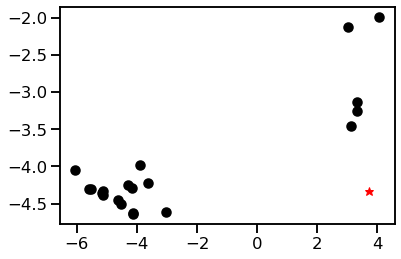

In [91]:
plt.scatter(targetsreduced5[:,0],targetsreduced5[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# Simulate the L96 configurations

In [ ]:
def simulate(params, Xdata):
    l96param = AMIP(Xdata=Xdata,
                    K=36,
                    save_dt=0.001,
                    X_init=Xdata[0,:],
                    h=params[0],
                    F=10,
                    c=params[1],
                    b=params[2]) 
    l96param.iterate(100)
    return l96param

In [ ]:
configs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior_classic_AMIP.csv").values
configs.tolist()

In [ ]:
#pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA.csv").to_latex()

In [ ]:
simus = [simulate(i, l96_two_truth.history.X) for i in configs.tolist()]

In [ ]:
simus_metrics = [ii.mean_stats(ax=0)[list(range(36,36*2))+list(range(36*4,36*5)),] for ii in simus]

In [ ]:
simus_metrics = np.array(simus_metrics)
simus_metrics.shape

In [ ]:
simusreduced = reduceL96pca_usingwave1(simus_metrics, sc, pc)
simusreduced.shape

In [ ]:
simus_df = pd.DataFrame()

for i in range(simusreduced.shape[1]):
    simus_df['pc'+str(i)] = simusreduced[:,i]
    
simus_df.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/configs_metrics_newPCA_PhysPrior_classic_AMIP.csv', index=False)

In [ ]:
simus_df

### add obs vector

In [ ]:
simus_df.loc[len(simus_df)]=list(Obsreduced[0,:])

In [ ]:
simus_df

In [ ]:
simusdftranspose = simus_df.T
simusdftranspose.columns = ['config0', 'config1', 'config2', 'config3','Obs']
simusdftranspose

In [ ]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

figure, axes = plt.subplots(1, 3, figsize=(30,5))

simusdftranspose.plot(ax=axes[0])#, color=[cycle[0], cycle[1], cycle[3], cycle[2]]

sns.kdeplot(simus[0].history.X.mean(axis=1), label='config0', ax=axes[1])
sns.kdeplot(simus[1].history.X.mean(axis=1), label='config1', ax=axes[1])
sns.kdeplot(simus[2].history.X.mean(axis=1), label='config2', ax=axes[1])
sns.kdeplot(simus[3].history.X.mean(axis=1), label='config3', ax=axes[1])
sns.kdeplot(l96_two_truth.history.X.mean(axis=1), label='Obs', ax=axes[1])
axes[1].legend()

sns.kdeplot(simus[0].history.Y_mean.mean(axis=1), label='config0', ax=axes[2])
sns.kdeplot(simus[1].history.Y_mean.mean(axis=1), label='config1', ax=axes[2])
sns.kdeplot(simus[2].history.Y_mean.mean(axis=1), label='config2', ax=axes[2])
sns.kdeplot(simus[3].history.Y_mean.mean(axis=1), label='config3', ax=axes[2])
sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', ax=axes[2])
axes[2].legend()

In [ ]:
bx_df_Ymean = pd.DataFrame()
bx_df_Ymean['config0'] = simus[0].history.Y_mean.mean(axis=0)
bx_df_Ymean['config1'] = simus[1].history.Y_mean.mean(axis=0)
bx_df_Ymean['config2'] = simus[2].history.Y_mean.mean(axis=0)
bx_df_Ymean['config3'] = simus[3].history.Y_mean.mean(axis=0)

bx_df_Ymean['AvgConfig'] = 0.25*(simus[0].history.Y_mean.mean(axis=0)+
                                 simus[1].history.Y_mean.mean(axis=0)+
                                simus[2].history.Y_mean.mean(axis=0)+
                                simus[3].history.Y_mean.mean(axis=0))
bx_df_Ymean['Obs'] = TrueTraj[0:36*1,]
bx_df_Ymean.boxplot()